# API quickstart

In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')

## 1. Model creation

Models in PyMC3 are centered around the `Model` class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a `with` context:

In [2]:
with pm.Model() as model:
    # Model definition
    pass

We discuss RVs further below but let's create a simple model to explore the `Model` class.

In [3]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))

In [4]:
model.basic_RVs

[mu, obs]

In [5]:
model.free_RVs

[mu]

In [6]:
model.observed_RVs

[obs]

In [7]:
model.logp({'mu': 0})

array(-135.1902745717962)

**Warning**
It's worth highlighting one of the counter-intuitive design choices with logp. 
The API makes the `logp` look like an attribute, when it actually puts together a function based on the current state of the model. 

The current design is super maintainable, does terrible if the state stays constant, and great if the state keeps changing, for reasons of design we assume that `Model` isn't static, in fact it's best in our experience and avoids bad results. 

If you need to use `logp` in an inner loop and it needs to be static, simply use something like `logp = model.logp` below. You can see the caching effect with the speed up below. 

In [8]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

The slowest run took 4.45 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 35 µs per loop
10000 loops, best of 3: 26.6 µs per loop


## 2. Probability Distributions

Every probabilistic program consists of observed and unobserved Random Variables (RVs). Observed RVs are defined via likelihood distributions, while unobserved RVs are defined via prior distributions. In PyMC3, probability distributions are available from the main module space:

In [9]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean.
 |  sd : float
 |      Standard deviation (sd > 0).
 |  tau : float
 |      Precision (tau > 0).
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distr

In the PyMC3 module, the structure for probability distributions looks like this:

[pymc3.distributions](http://pymc-devs.github.io/pymc3/api/distributions.html)<br>
 |- [continuous](http://pymc-devs.github.io/pymc3/api/distributions/continuous.html)<br>
 |- [discrete](http://pymc-devs.github.io/pymc3/api/distributions/discrete.html)<br>
 |- [timeseries](http://pymc-devs.github.io/pymc3/api/distributions/timeseries.html)<br>
 |- [mixture](http://pymc-devs.github.io/pymc3/api/distributions/mixture.html)<br>

In [10]:
dir(pm.distributions.mixture)

['Discrete',
 'Distribution',
 'Mixture',
 'Normal',
 'NormalMixture',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_discrete',
 'bound',
 'draw_values',
 'generate_samples',
 'get_tau_sd',
 'get_variable_name',
 'logsumexp',
 'np',
 'tt']

### Unobserved Random Variables

Every unobserved RV has the following calling signature: name (str), parameter keyword arguments. Thus, a normal prior can be defined in a model context like this:

In [11]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)

As with the model, we can evaluate its logp:

In [12]:
x.logp({'x': 0})

array(-0.9189385332046727)

### Observed Random Variables

Observed RVs are defined just like unobserved RVs but require data to be passed into the `observed` keyword argument:

In [13]:
with pm.Model():
    obs = pm.Normal('x', mu=0, sd=1, observed=np.random.randn(100))

`observed` supports lists, `numpy.ndarray`, `theano` and `pandas` data structures.

### Deterministic transforms

PyMC3 allows you to freely do algebra with RVs in all kinds of ways:

In [14]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

While these transformations work seamlessly, its results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use `pm.Determinstic`:

In [15]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    plus_2 = pm.Deterministic('x plus 2', x + 2)

Note that `plus_2` can be used in the identical way to above, we only tell PyMC3 to keep track of this RV for us.

### Automatic transforms of bounded RVs

In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

In [16]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1)

When we look at the RVs of the model, we would expect to find `x` there, however:

In [17]:
model.free_RVs

[x_interval__]

`x_interval__` represents `x` transformed to accept parameter values between -inf and +inf. In the case of an upper and a lower bound, a `LogOdd`s transform is applied. Sampling in this transformed space makes it easier for the sampler. PyMC3 also keeps track of the non-transformed, bounded parameters. These are common determinstics (see above): 

In [18]:
model.deterministics

[x]

When displaying results, PyMC3 will usually hide transformed parameters. You can pass the `include_transformed=True` parameter to many functions to see the transformed parameters that are used for sampling.

You can also turn transforms off:

In [19]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)
    
print(model.free_RVs)

[x]


### Lists of RVs / higher-dimensional RVs

Above we have seen to how to create scalar RVs. In many models, you want multiple RVs. There is a tendency (mainly inherited from PyMC 2.x) to create list of RVs, like this:

In [20]:
with pm.Model():
    x = [pm.Normal('x_{}'.format(i), mu=0, sd=1) for i in range(10)] # bad

However, even though this works it is quite slow and not recommended. Instead, use the `shape` kwarg:

In [21]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=10) # good

`x` is now a random vector of length 10. We can index into it or do linear algebra operations on it:

In [22]:
with model:
    y = x[0] * x[1] # full indexing is supported
    x.dot(x.T) # Linear algebra is supported

### Initialization with test_values

While PyMC3 tries to automatically initialize models it is sometimes helpful to define initial values for RVs. This can be done via the `testval` kwarg:

In [23]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5)

x.tag.test_value

array([ 0.,  0.,  0.,  0.,  0.])

In [24]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([ 0.58550005,  0.19586392, -2.19206299, -1.15200385,  1.13329314])

This technique is quite useful to identify problems with model specification or initialization.

## 3. Inference

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

### 3.1 Sampling

The main entry point to MCMC sampling algorithms is via the `pm.sample()` function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don't pass anything.

In [25]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))
    
    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Average Loss = 150.92:   3%|▎         | 6545/200000 [00:00<00:11, 16437.29it/s]
Convergence archived at 7400
Interrupted at 7,400 [3%]: Average Loss = 156.53
100%|██████████| 1500/1500 [00:00<00:00, 3027.54it/s]


As you can see, on a continuous model, PyMC3 assigns the NUTS sampler, which is very efficient even for complex models. PyMC3 also runs variational inference (i.e. ADVI) to find good starting parameters for the sampler. Here we draw 1000 samples from the posterior and allow the sampler to adjust its parameters in an additional 500 iterations. These 500 samples are discarded by default:

In [26]:
len(trace)

1000

You can also run multiple chains in parallel using the `njobs` kwarg:

In [27]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))
    
    trace = pm.sample(njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 150.53:   4%|▍         | 8386/200000 [00:00<00:11, 16710.37it/s]
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 155.52
100%|██████████| 1000/1000 [00:00<00:00, 1462.08it/s]


Note, that we are now drawing 2000 samples, 500 samples for 4 chains each. The 500 tuning samples are discarded by default.

In [28]:
trace['mu'].shape

(2000,)

In [29]:
trace.nchains

4

In [30]:
trace.get_values('mu', chains=1).shape # get values of a single chain

(500,)

PyMC3, offers a variety of other samplers, found in `pm.step_methods`.

In [31]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SMC',
 'Slice']

Commonly used step-methods besides NUTS are `Metropolis` and `Slice`. **For almost all continuous models, `NUTS` should be preferred.** There are hard-to-sample models for which `NUTS` will be very slow causing many users to use `Metropolis` instead. This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex or it is badly initialized. In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample size or not converge properly at all. A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.

For completeness, other sampling methods can be passed to sample:

In [32]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))
    
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

100%|██████████| 1500/1500 [00:00<00:00, 11347.22it/s]


You can also assign variables to different step methods.

In [33]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))
    
    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace = pm.sample(10000, step=[step1, step2], njobs=4)

100%|██████████| 10500/10500 [00:09<00:00, 1125.34it/s]


### 3.2 Analyze sampling results

The most common used plot to analyze sampling results is the so-called trace-plot:

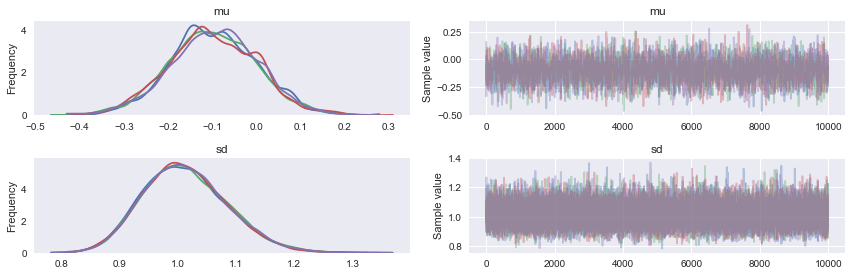

In [34]:
pm.traceplot(trace);

Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic:

In [35]:
pm.gelman_rubin(trace)

{'mu': 1.0002705510318985,
 'sd': 0.99998336390229592,
 'sd_log__': 0.99998637638337262}

These are also part of the `forestplot`:

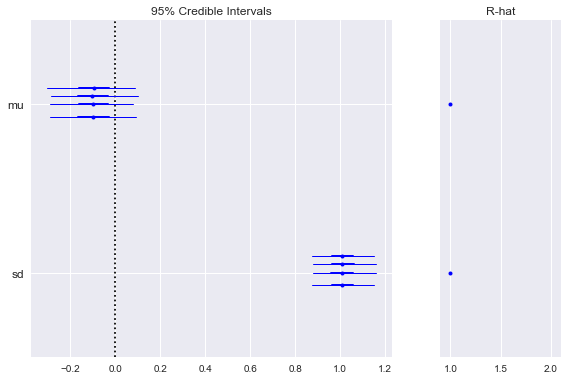

In [36]:
pm.forestplot(trace);

Finally, for a plot of the posterior that is inspired by the book [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/), you can use the:

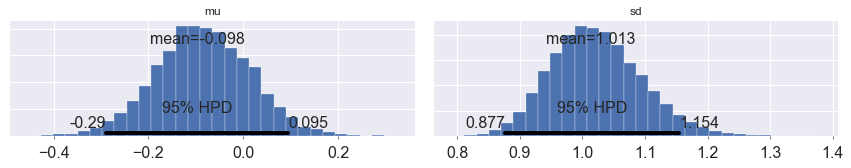

In [37]:
pm.plot_posterior(trace);

For high-dimensional models it becomes cumbersome to look at all parameter's traces. When using `NUTS` we can look at the energy plot to assess problems of convergence:

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 0.031327:   3%|▎         | 5727/200000 [00:00<00:17, 11147.89it/s]
Convergence archived at 5900
Interrupted at 5,900 [2%]: Average Loss = 2.1251
100%|██████████| 1000/1000 [00:04<00:00, 204.65it/s]


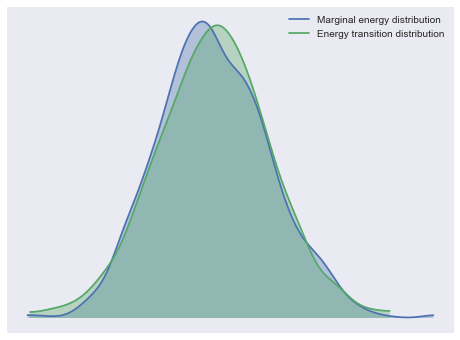

In [38]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=100)    
    trace = pm.sample(njobs=4)
    
pm.energyplot(trace);

For more information on sampler stats and the energy plot, see [here](http://pymc-devs.github.io/pymc3/notebooks/sampler-stats.html). For more information on identifying sampling problems and what to do about them, see [here](http://pymc-devs.github.io/pymc3/notebooks/Diagnosing_biased_Inference_with_Divergences.html).

### 3.3 Variational inference

PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc3.fit()`.

In [39]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))
    
    approx = pm.fit()

Average Loss = 163.67: 100%|██████████| 10000/10000 [00:00<00:00, 13061.46it/s]
Finished [100%]: Average Loss = 163.66


The returned `Approximation` object has various capabilities, like drawing samples from the approximated posterior, which we can analyse like a regular sampling run:

In [40]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 2 variables>

The `variational` submodule offers a lot of flexibility in which VI to use and follows an object oriented design. For example, full-rank ADVI estimates a full covariance matrix:

In [41]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1, .5], [.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.fit(method='fullrank_advi')

Average Loss = 0.0065215: 100%|██████████| 10000/10000 [00:03<00:00, 3021.17it/s]
Finished [100%]: Average Loss = 0.0063589


An equivalent expression using the object-oriented interface is:

In [42]:
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit()

Average Loss = 0.010004: 100%|██████████| 10000/10000 [00:03<00:00, 3096.42it/s]
Finished [100%]: Average Loss = 0.010116


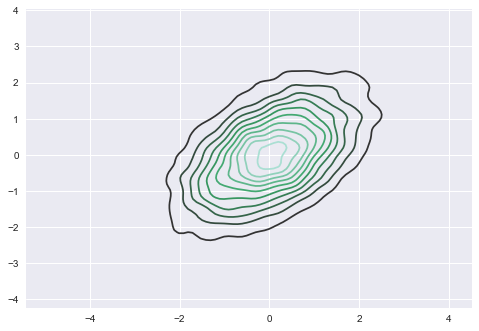

In [43]:
plt.figure()
trace = approx.sample(10000)
sns.kdeplot(trace['x'])

Stein Variational Gradient Descent (SVGD) uses particles to estimate the posterior:

In [44]:
w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
with pm.Model() as model:
    pm.NormalMixture('x', w=w, mu=mu, sd=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.))

100%|██████████| 10000/10000 [01:00<00:00, 165.47it/s]


/Users/peadarcoyle/anaconda/envs/pymc3_dev/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


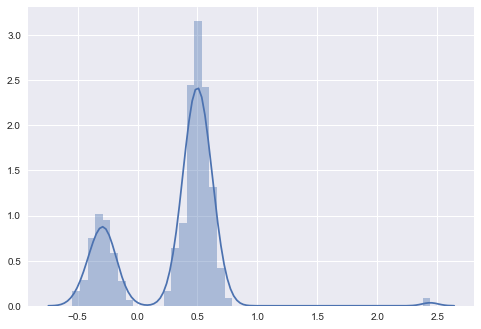

In [45]:
plt.figure()
trace = approx.sample(10000)
sns.distplot(trace['x']);

For more information on variational inference, see [these examples](http://pymc-devs.github.io/pymc3/examples.html#variational-inference).

## 4. Posterior Predictive Sampling

The `sample_ppc()` function performs prediction on hold-out data and posterior predictive checks.

In [46]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=data)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 155.98:   6%|▌         | 12061/200000 [00:01<00:15, 11886.92it/s]
Convergence archived at 12100
Interrupted at 12,100 [6%]: Average Loss = 187.13
100%|██████████| 1000/1000 [00:00<00:00, 1703.97it/s]


In [47]:
with model:
    post_pred = pm.sample_ppc(trace, samples=500, size=len(data))

100%|██████████| 500/500 [00:00<00:00, 2876.26it/s]


`sample_ppc()` returns a dict with a key for every observed node:

In [48]:
post_pred['obs'].shape

(500, 100)

/Users/peadarcoyle/anaconda/envs/pymc3_dev/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


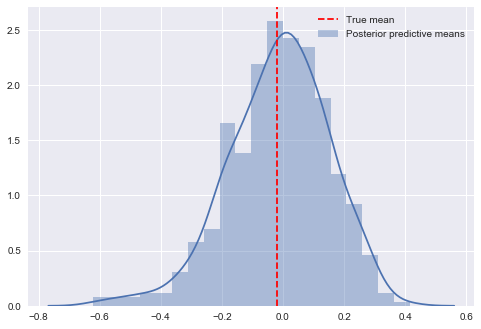

In [49]:
plt.figure()
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(data.mean(), color='r', ls='--', label='True mean')
ax.legend()

## 4.1 Predicting on hold-out data

In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. While we plan to improve the API in this regard, this can currently be achieved with a `theano.shared` variable. These are theano tensors whose values can be changed later. Otherwise they can be passed into PyMC3 just like any other numpy array or tensor.

In [50]:
import theano

x = np.random.randn(100)
y = x > 0

x_shared = theano.shared(x)
y_shared = theano.shared(y)

with pm.Model() as model:
    coeff = pm.Normal('x', mu=0, sd=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli('obs', p=logistic, observed=y_shared)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 29.296:   5%|▍         | 9252/200000 [00:00<00:14, 13184.49it/s]
Convergence archived at 9500
Interrupted at 9,500 [4%]: Average Loss = 43.022
100%|██████████| 1000/1000 [00:00<00:00, 2538.10it/s]


Now assume we want to predict on unseen data. For this we have to change the values of `x_shared` and `y_shared`. Theoretically we don't need to set `y_shared` as we want to predict it but it has to match the shape of `x_shared`.

In [51]:
x_shared.set_value([-1, 0, 1.])
y_shared.set_value([0, 0, 0]) # dummy values

with model:
    post_pred = pm.sample_ppc(trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 802.20it/s]


In [52]:
post_pred['obs'].mean(axis=0)

array([ 0.014,  0.514,  0.97 ])